***Домашнее задание №2 (построение собственных сетей CNN + FFN)***

В этом домашнем задании вы построите нейронную сеть с использованием сверточных и линейных слоев  для задачи классификации твитов. 
С корпусом мы работали на паре про перцептрон.
Посмотреть и скачать корпус можно из источника http://study.mokoron.com, (либо сразу по прямым ссылкам в ноутбуке)

```
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv 
```

Решите задачу , используя две следующие архитектуры, для каждой посчитайте accuracy, precision, recall:

I.  CNN на уровне слов:
модель берет слова, пропускает их через Embedding слой. По эмбеддингам проходит CNN c фильтрами с разным окном, полученные результаты конкатенируются друг с другом по глубине, по результату конкатенации еще один сверточный слой, далее max pooling over time, на выходе линейный слой + сигмоида, функция потерь  BCELoss. (модель аналогична тому, что мы делали на паре по сверткам, но на уровне слов, а не символов)



II. комбинация эмбеддингов и символьных признаков:
У этой модели два входа, один для эмбеддингов слов (предобученных или обучаемых), из них берем max или  mean, делаем вектор для предложения, поверх линейный слой - получаем вектор X.
 Другой вход сети для символьного представления слов (это обучаемый Embedding  слой, он будет брать на вход batch_size x symbols_len и сопоставлять каждому  символу в каждом слове один эмбеддинг). Следующий слой сверточный, примените фильтры разных размеров. Результаты  агрегируются с помощью  max pooling over time и полученные векторы конкатенируются с вектором X.

 Далее линейный слой + сигмоида, функция потерь  BCELoss.

***Баллы:*** 

Embedding слой обучается внутри первой модели -- 1 балл 

подгружаются обученные эмбеддинги для русского языка или
fasttext эмбеддинги обучаются на всем корпусе с нуля  и далее подгружаются в модель -- 1 балл 

Первая модель правильно построена и обучается -- 1 балл 

Правильно подготовленный класс Dataset  для второй архитектуры (теперь вам нужно два словаря (word2id и symbol2id) и две матрицы для кодирования предложения: одна размера batch_size x seq_len,  другая  batch_size x sybmols_len ) -- 2 балла 

Вторая модель правильно построена и обучается -- 2 балла 

Для первой модели показано, что качество можно улучшить засчет работы с гиперпараметрами и/или доведения архитектуры (помогло изменение количества/размера фильтров, размера слоя/эмбеддингов, добавили Dropout и спаслись от переобучения, добавили слоев и т.д.) -- 1 балл 

Для второй модели показано, что качество можно улучшить засчет работы с гиперпараметрами и/или доведения архитектуры (помогло изменение количества/размера фильтров, размера слоя/эмбеддингов, добавили Dropout и спаслись от переобучения, добавили слоев и т.д.) -- 1 балл 

Сделана попытка анализа предсказаний, на примерах из тестовой выборки показано, какие случаи даются легко, а какие хуже - 1 балл 





In [41]:
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv 

--2021-11-26 18:38:02--  https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r6u59ljhhjdg6j0/negative.csv [following]
--2021-11-26 18:38:02--  https://www.dropbox.com/s/raw/r6u59ljhhjdg6j0/negative.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 404 Not Found
2021-11-26 18:38:02 ERROR 404: Not Found.

--2021-11-26 18:38:02--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2021-11-26 18:38:02--  https:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from collections import Counter
from typing import List
from sklearn.model_selection import train_test_split

In [8]:
!pip install --quiet torchmetrics

     |████████████████████████████████| 329 kB 5.1 MB/s 


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader

from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
#спасибо этой домашке, я узнала про :
from torchmetrics.functional import precision, recall, f1

In [10]:
from gensim.models import FastText

In [43]:
colnames = ['id',1,'nickname','text','tone',5,6,7,8,9,10,11]
neg = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None,  names=colnames)
pos = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=colnames)

In [44]:
neg.head(3)

,id,1,nickname,text,tone,5,6,7,8,9,10,11
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0


In [45]:
pos.head(3)

,id,1,nickname,text,tone,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0


In [46]:
def bt(token_pattern=r'(?u)\b\w\w+\b')-> List:
    return re.compile(token_pattern).findall
tokenizer=bt()
print(tokenizer('ПривЕт, как дела +7904 fghakbm ? ! ***'))
 
def tokenize_line(line: str):
    if isinstance(line, str):
        return [w.lower() for w in tokenizer(line)]
    else:
        return 'нет текста'
print(tokenize_line('ПривЕт, как дела +7904 fghakbm ? ! ***'))

['ПривЕт', 'как', 'дела', '7904', 'fghakbm']
['привет', 'как', 'дела', '7904', 'fghakbm']


In [47]:
def tokenize_line2(line:str) -> List:
  if isinstance(line, str):
    line = ' '.join(tokenizer(line))
    line = re.sub('[0-9]|[A-Za-z]', '', line)
    line = [w.lower() for w in line.split() if len(w)<20 
            and not w.startswith(('@', 'http')) and
                                       w != 'RT']
    return line

In [48]:
line = 'ПривЕт, как дела +7904 fghakbm ? ! *** чщпсщрщрссщрщрсшаааггввшвллидцяхьувзькдсьзцябхцьязцтчзучщуьчуьчу'
print(tokenize_line(line))
print(tokenize_line2(line))

['привет', 'как', 'дела', '7904', 'fghakbm', 'чщпсщрщрссщрщрсшаааггввшвллидцяхьувзькдсьзцябхцьязцтчзучщуьчуьчу']
['привет', 'как', 'дела']


In [49]:
df = pd.concat([pos, neg], axis=0)
df.head(3)

,id,1,nickname,text,tone,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0


In [50]:
print(neg.shape, pos.shape, df.shape)

(111923, 12) (114911, 12) (226834, 12)


In [51]:
df['tokens'] = df['text'].apply(tokenize_line)
df['tokens2'] = df['text'].apply(tokenize_line2)

In [52]:
df = df[df['tokens2'] != 0].reset_index()

In [53]:
all_toks = []
for t in df['tokens']:
  all_toks.extend(t)
all_toks_counter = Counter(all_toks)


all_toks2 = []
for t in df['tokens2']:
  all_toks2.extend(t)
all_toks_counter2 = Counter(all_toks2)

In [54]:
print('Число токенов, полученных первым способом, встретившихся в корпусе не более 5 раз: ',
      len([v for v in all_toks_counter.values() if v < 5]), '\n',
          'Число токенов, полученных вторым способом, встретившихся в корпусе не более 5 раз: ',
      len([v for v in all_toks_counter2.values() if v < 5]))

Число токенов, полученных первым способом, встретившихся в корпусе не более 5 раз:  256791 
 Число токенов, полученных вторым способом, встретившихся в корпусе не более 5 раз:  139988


In [55]:
all_toks_counter.most_common()[-10:]

[('выключался', 1),
 ('36qncogdxr', 1),
 ('qelasocadij', 1),
 ('пхжааххв', 1),
 ('qnoddqzuz7', 1),
 ('taaannyaaa', 1),
 ('вправляет', 1),
 ('lisaberoud', 1),
 ('приплатить', 1),
 ('втащили', 1)]

In [56]:
all_toks_counter.most_common(10)

[('не', 75029),
 ('на', 38189),
 ('rt', 38118),
 ('что', 36099),
 ('http', 33063),
 ('co', 33036),
 ('как', 23563),
 ('меня', 21874),
 ('то', 20882),
 ('это', 19822)]

In [57]:
all_toks_counter2.most_common()[-10:]

[('пидораса', 1),
 ('доисторические', 1),
 ('телики', 1),
 ('тренюю', 1),
 ('шлегель', 1),
 ('выключался', 1),
 ('пхжааххв', 1),
 ('вправляет', 1),
 ('приплатить', 1),
 ('втащили', 1)]

In [58]:
all_toks_counter2.most_common(10)

[('не', 75035),
 ('_', 43300),
 ('на', 38197),
 ('что', 36103),
 ('как', 23572),
 ('меня', 21876),
 ('то', 20897),
 ('это', 19826),
 ('так', 19111),
 ('мне', 18925)]

Мне кажется более разумным взять токены из второй предобработки, если что, вернусь к первому способу.

In [59]:
new_tone = [t if t==1 else 0 for t in df['tone']]
df['tone'] = new_tone
train_df, val_df = train_test_split(df, test_size=0.25, shuffle=True, random_state=10, stratify=df['tone'])

In [60]:
df[df['tone'] == 0].head(2)

,index,id,1,nickname,text,tone,5,6,7,8,9,10,11,tokens,tokens2
114911,0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,0,0,0,0,8064,111,94,2,"[на, работе, был, полный, пиддес, так, каждое,...","[на, работе, был, полный, пиддес, так, каждое,..."
114912,1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",0,0,0,0,26,42,39,0,"[коллеги, сидят, рубятся, urban, terror, из, з...","[коллеги, сидят, рубятся, из, за, долбанной, в..."


Припишем каждому слову айдишник (как больно, что все это надо делать руками, а не использовать прекрасные предобученные берты, например)

Нулевой айди будет иметь паддинг (есть периодически проблема с отрицательными значениями (хотела сделать -1, но вспомнила, что иногда так лучше не делать)).

# TweeterDataset

In [61]:
word2id = {'PAD':0}

for word in all_toks_counter2.keys():
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [121]:
print(f'Число уникальных токенов - {len(word2id)}')

Число уникальных токенов - 171903


In [62]:
class TweeterDataset(Dataset):

    def __init__(self, dataset, word2id, device):
        self.dataset = dataset['tokens2'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = device

    def __len__(self):
        return self.length

    def __getitem__(self, idx): 
        tokens = self.dataset[idx]
        ids = torch.LongTensor([self.word2id[tok] for tok in tokens if tok in self.word2id])
        y = [self.target[idx]]
        return ids, y

    # пишу этот метод сюда, потом при итерации по батчам пригодится
    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [74]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 128

train_dataset = TweeterDataset(train_df, word2id, device)
val_dataset = TweeterDataset(val_df, word2id, device)

train_sampler = RandomSampler(train_dataset)
val_sampler = RandomSampler(val_dataset)

train_dataloader = DataLoader(train_dataset,
                              collate_fn = train_dataset.collate_fn,
                              sampler=train_sampler,
                              batch_size=batch_size)
val_dataloader = DataLoader(val_dataset,
                            collate_fn = val_dataset.collate_fn,
                            sampler=val_sampler,
                            batch_size=batch_size)

Обучаем FastText на всем корпусе (в df лежат скончаченные negative, positive, использую токены, полученные функцией tokenize_line, надеюсь, все будет хорошо.)

Из дз по НИСу заметила, что все-таки эмбеддинги размера 300 дают как больше нужной информации о слове и в лучшую сторону влияют на качество модели, поэтому решила сделать классические 300 (а не 100, например, который тоже достаточно популярный размер эмбеддингов, и не 512, потому что юбоюсь слишком сильно перегрузить память и тд)

UPD: по итогу победили эмбеддинги размера 100, была не права!

# FastText

In [138]:
embedding_size = 100
model_ft = FastText(sentences=df['tokens2'].values, size=embedding_size)
ft_weights = np.zeros((len(word2id), embedding_size))
count = 0
for w, i in word2id.items():
    if w != 'PAD':
      try:
          ft_weights[i] = model_ft.wv[w]    
      except:
        count += 1
        ft_weights[i] = np.random.normal(0,0.1,embedding_size)
    else:
      pass

# Train, Evaluate Functions

Пишем функции для трейна и валидации (боже, храни семинары ФКН!)

In [107]:
def train(train_dataloader, val_dataloader,
          model, optimizer,
          criterion, epochs,
          metric=f1, scheduler=None,
          verbose=False,
          device=device):
  losses = [] 
  f1s = []
  val_losses = []
  f1s = []
  val_f1s = []
  precs = []
  val_precs = []
  recs = []
  val_recs = []
        
  for epoch in tqdm(range(epochs)):

        train_loss, train_f1s, train_precs, train_recs = train_epoch(train_dataloader, model, criterion, metric, device)

        losses.append(train_loss)
        f1s.append(train_f1s)
        precs.append(train_precs)
        recs.append(train_recs)

        val_loss, val_metric, val_precss, val_recss = evaluate(val_dataloader, model, criterion, metric, device)
        print('----------')

        val_losses.append(val_loss)
        val_f1s.append(val_metric)
        val_precs.append(val_precss)
        val_recs.append(val_recss)
        
        model.train()
        if scheduler:
            if type(scheduler) is torch.optim.lr_scheduler.ReduceLROnPlateau:
                scheduler.step(val_loss)
            else:
                scheduler.step()
        print(f'Epoch {epoch+1}:')
        print(f'Train loss: {train_loss}, Train metric: {train_f1s}')


  return losses, val_losses, f1s, val_f1s, precs, val_precs, recs, val_recs

def train_epoch(dataloader, model, criterion, metric=f1, device=device, verbose=False):
    model.train()  
    model.to(device)
    train_loss = []
    train_f1s = []
    train_precs = []
    train_recs = []
    for i, (*x, y) in enumerate(dataloader, 1):
            optimizer.zero_grad()
            preds = model(*x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            batch_metric = metric(preds.round().long(), y.long(), ignore_index=0)
            train_f1s.append(batch_metric.cpu().numpy())
            batch_metric = precision(preds.round().long(), y.long(), ignore_index=0)
            train_precs.append(batch_metric.cpu().numpy())
            batch_metric = recall(preds.round().long(), y.long(), ignore_index=0)
            train_recs.append(batch_metric.cpu().numpy())
            if verbose:
                progress_bar.update(y.shape[0])

    return np.mean(train_loss), np.mean(train_f1s), np.mean(train_precs), np.mean(train_recs)


def evaluate(dataloader, model, criterion, metric, device=device, verbose=False):
    epoch_loss = []
    epoch_metric = []
    val_precs = []
    val_recs = []
    model.eval() 
    with torch.no_grad():
        for i, (*x, y) in enumerate(dataloader):
            preds = model(*x)
            loss = criterion(preds, y)
            epoch_loss.append(loss.item())
            batch_metric = metric(preds.round().long(), y.long(), ignore_index=0)
            epoch_metric.append(batch_metric.cpu().numpy())
            batch_metric = precision(preds.round().long(), y.long(), ignore_index=0)
            val_precs.append(batch_metric.cpu().numpy())
            batch_metric = recall(preds.round().long(), y.long(), ignore_index=0)
            val_recs.append(batch_metric.cpu().numpy())
    print(f'Val loss: {np.mean(epoch_loss)}, Val metric: {np.mean(epoch_metric)}')
    
    return np.mean(epoch_loss), np.mean(epoch_metric), np.mean(val_precs), np.mean(val_recs)

# Model 1 - CNN на уровне слов

Для начала не использую никакие веса (которые, вообще-то лежат пока в запасе и ждут своего звездного часа), я повозилась с сеткой и тут сохраняю лучшее, что смогла сделать, помимо прекраснейшей инструкции: "навешивание" дропаут-слоя с достаточно, так сказать, большим значением p (так реально меньше сетка переобучатся - первый раз, когда это реально прям *очень сильно помогло*)


Макс-пулинг, увеличила - жизнь стала лучше.

P.S.: я навертела ерунду с прогресс-баром, это полная ерунда и не оценивается, энивей прошу прощения, не хватило времени красиво исправить (((( постараюсь в след. раз быть аккуратней с табуляцией и тд)

P.S.2: я случайно удалила первые эксперименты, оставила (заново прогнала) один самый отстойный, чтобы показать, что подбор гиперпараметров (в моем случае был достаточно основанный на теор. знаниях, по-хорошему люди делают GridSearch, но для колаба это слишком тяжко)

In [146]:
class CNN_simple(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pretrained_weights=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_weights is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
            self.embedding.weight.requires_grad = False
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.conv = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.permute(0,2,1)
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        concat = self.pooling(self.relu(self.conv(concat)))
        pooling = concat.max(2)[0] 
        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [147]:
model = CNN(len(word2id), 100, 1)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()
train_loss, val_loss, train_f1, val_f1, precs, val_precs, recs, val_recs = train(train_dataloader=train_dataloader,
                                               val_dataloader=val_dataloader,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=10,
                                               verbose=True,
                                               metric=f1)

 10%|█         | 1/10 [00:38<05:48, 38.76s/it]

Val loss: 0.6510300638976397, Val metric: 0.6609646677970886
----------
Epoch 1:
Train loss: 0.6684917938440366, Train metric: 0.6000011563301086


 20%|██        | 2/10 [01:17<05:11, 38.96s/it]

Val loss: 0.6331453195831798, Val metric: 0.6891135573387146
----------
Epoch 2:
Train loss: 0.6347983431547208, Train metric: 0.6463316679000854


 30%|███       | 3/10 [01:56<04:32, 38.91s/it]

Val loss: 0.6189384545023376, Val metric: 0.6990368962287903
----------
Epoch 3:
Train loss: 0.612186081292934, Train metric: 0.6703751087188721


 40%|████      | 4/10 [02:35<03:53, 38.85s/it]

Val loss: 0.606603475438582, Val metric: 0.6953703165054321
----------
Epoch 4:
Train loss: 0.5931957926068987, Train metric: 0.6880457997322083


 50%|█████     | 5/10 [03:14<03:13, 38.77s/it]

Val loss: 0.5984113698338603, Val metric: 0.7081239819526672
----------
Epoch 5:
Train loss: 0.5779997766690147, Train metric: 0.7008727788925171


 60%|██████    | 6/10 [03:52<02:34, 38.74s/it]

Val loss: 0.58942454925797, Val metric: 0.7182284593582153
----------
Epoch 6:
Train loss: 0.5644826307108528, Train metric: 0.7105743288993835


 70%|███████   | 7/10 [04:31<01:56, 38.84s/it]

Val loss: 0.5844260678366497, Val metric: 0.7251599431037903
----------
Epoch 7:
Train loss: 0.5515819894191915, Train metric: 0.7218500971794128


 80%|████████  | 8/10 [05:10<01:17, 38.87s/it]

Val loss: 0.5769336576665844, Val metric: 0.7225741147994995
----------
Epoch 8:
Train loss: 0.5397324647670402, Train metric: 0.7309826612472534


 90%|█████████ | 9/10 [05:49<00:38, 38.88s/it]

Val loss: 0.5713223727705242, Val metric: 0.7239679098129272
----------
Epoch 9:
Train loss: 0.528726122209004, Train metric: 0.7379292845726013


100%|██████████| 10/10 [06:28<00:00, 38.88s/it]

Val loss: 0.5677344292939246, Val metric: 0.733214259147644
----------
Epoch 10:
Train loss: 0.5192407941907868, Train metric: 0.7455936074256897


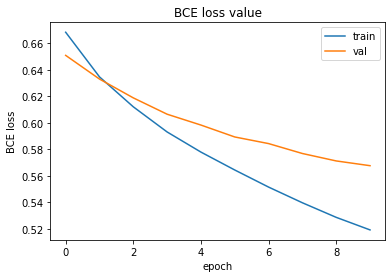

In [148]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

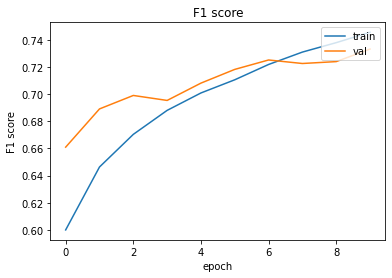

In [149]:
plt.plot(train_f1)
plt.plot(val_f1)
plt.title('F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

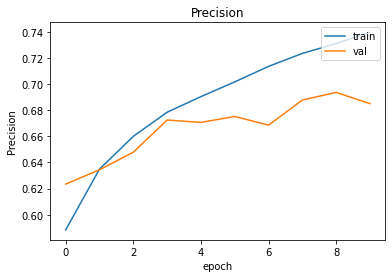

In [150]:
plt.plot(precs)
plt.plot(val_precs)
plt.title('Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

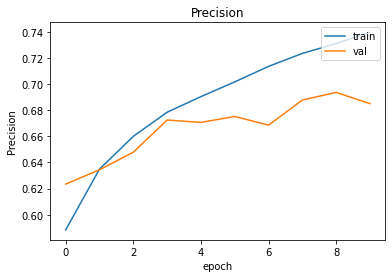

In [151]:
plt.plot(precs)
plt.plot(val_precs)
plt.title('Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Тут, как было написано выше, чуть поиграем с дропаутами и все такое

In [108]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, out_features, pretrained_weights=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        if pretrained_weights is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
            self.embedding.weight.requires_grad = False
        #по "временному" dimension делается свертка
        self.bigrams = nn.Conv1d(in_channels=embedding_size, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_size, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=3, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=out_features)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.permute(0,2,1)
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded)))) #чуть уменьшаем признаковое пространство, а что делать, так лучше работаит
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        pool1 = feature_map_bigrams.max(2)[0]
        pool2 = feature_map_trigrams.max(2)[0]
        concat = torch.cat((pool1, pool2), 1)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [114]:
model = CNN(len(word2id), 100, 1)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

In [115]:
device

device(type='cuda')

In [116]:
train_loss, val_loss, train_f1, val_f1, precs, val_precs, recs, val_recs = train(train_dataloader=train_dataloader,
                                               val_dataloader=val_dataloader,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=10,
                                               verbose=True,
                                               metric=f1)

 10%|█         | 1/10 [00:38<05:48, 38.74s/it]

Val loss: 0.6517390258408882, Val metric: 0.6650829315185547
----------
Epoch 1:
Train loss: 0.6691533630951902, Train metric: 0.5999371409416199


 20%|██        | 2/10 [01:17<05:10, 38.76s/it]

Val loss: 0.6357462330981418, Val metric: 0.6944575309753418
----------
Epoch 2:
Train loss: 0.6349921990157966, Train metric: 0.6454562544822693


 30%|███       | 3/10 [01:56<04:31, 38.79s/it]

Val loss: 0.62054012272809, Val metric: 0.7023982405662537
----------
Epoch 3:
Train loss: 0.6129377225287875, Train metric: 0.6680210828781128


 40%|████      | 4/10 [02:35<03:52, 38.81s/it]

Val loss: 0.6080297204825256, Val metric: 0.703310489654541
----------
Epoch 4:
Train loss: 0.5940627097859419, Train metric: 0.6865477561950684


 50%|█████     | 5/10 [03:14<03:14, 38.85s/it]

Val loss: 0.5984924134907422, Val metric: 0.7166231274604797
----------
Epoch 5:
Train loss: 0.5787303452653096, Train metric: 0.6995781064033508


 60%|██████    | 6/10 [03:52<02:35, 38.84s/it]

Val loss: 0.5892439865851188, Val metric: 0.7080183029174805
----------
Epoch 6:
Train loss: 0.5647030480374071, Train metric: 0.7113673090934753


 70%|███████   | 7/10 [04:31<01:56, 38.83s/it]

Val loss: 0.5837928362794824, Val metric: 0.7261782884597778
----------
Epoch 7:
Train loss: 0.5519257736385317, Train metric: 0.7211155891418457


 80%|████████  | 8/10 [05:10<01:17, 38.77s/it]

Val loss: 0.5774835519291259, Val metric: 0.7303116321563721
----------
Epoch 8:
Train loss: 0.538473376990261, Train metric: 0.7305161952972412


 90%|█████████ | 9/10 [05:49<00:38, 38.92s/it]

Val loss: 0.5710060530686164, Val metric: 0.729766845703125
----------
Epoch 9:
Train loss: 0.5282026186473388, Train metric: 0.7393754124641418


100%|██████████| 10/10 [06:28<00:00, 38.83s/it]

Val loss: 0.5671071868624773, Val metric: 0.7367988228797913
----------
Epoch 10:
Train loss: 0.5181119450052878, Train metric: 0.7461197972297668


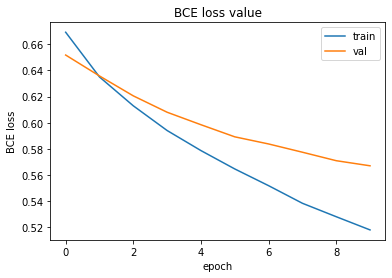

In [117]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

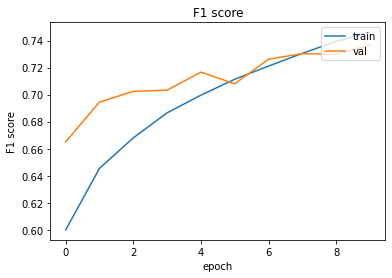

In [118]:
plt.plot(train_f1)
plt.plot(val_f1)
plt.title('F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

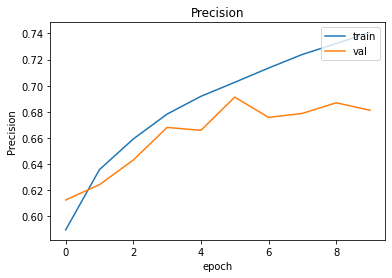

In [119]:
plt.plot(precs)
plt.plot(val_precs)
plt.title('Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

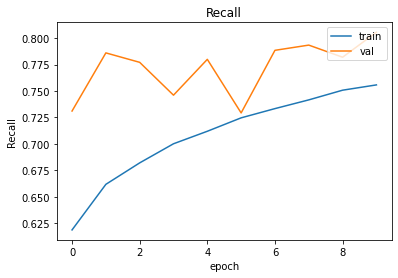

In [120]:
plt.plot(recs)
plt.plot(val_recs)
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Лосс падает,  f1 растет, жизнь прекрасно. Особо не пахнет переобучением, это очень-очень радует, но хочется улучшить качество модельки (после кучи попыток и страданий), попробуем.
Эта модель - самая лучшая, ниже - сработали не лучше этой.

## Model 1: уменьшим learning rate :)

In [122]:
model = CNN(len(word2id), 100, 1)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

In [123]:
train_loss, val_loss, train_f1, val_f1, precs, val_precs, recs, val_recs = train(train_dataloader=train_dataloader,
                                               val_dataloader=val_dataloader,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=10,
                                               verbose=True,
                                               metric=f1)

 10%|█         | 1/10 [00:38<05:48, 38.69s/it]

Val loss: 0.6829429740035856, Val metric: 0.5640218257904053
----------
Epoch 1:
Train loss: 0.7028612066928606, Train metric: 0.5253835320472717


 20%|██        | 2/10 [01:17<05:10, 38.77s/it]

Val loss: 0.6754297420785234, Val metric: 0.614020049571991
----------
Epoch 2:
Train loss: 0.6857119853335215, Train metric: 0.5705634951591492


 30%|███       | 3/10 [01:56<04:32, 38.87s/it]

Val loss: 0.6705287050556492, Val metric: 0.6322234272956848
----------
Epoch 3:
Train loss: 0.6769356895210151, Train metric: 0.588345468044281


 40%|████      | 4/10 [02:35<03:53, 38.94s/it]

Val loss: 0.6665581694325885, Val metric: 0.6373040676116943
----------
Epoch 4:
Train loss: 0.6704908502729315, Train metric: 0.6000803112983704


 50%|█████     | 5/10 [03:14<03:14, 38.97s/it]

Val loss: 0.6630870785799112, Val metric: 0.6385737657546997
----------
Epoch 5:
Train loss: 0.6650524712146673, Train metric: 0.6081936955451965


 60%|██████    | 6/10 [03:53<02:36, 39.03s/it]

Val loss: 0.6603628610436981, Val metric: 0.6467927694320679
----------
Epoch 6:
Train loss: 0.660270797489281, Train metric: 0.6140907406806946


 70%|███████   | 7/10 [04:32<01:57, 39.06s/it]

Val loss: 0.6579552978814185, Val metric: 0.6443702578544617
----------
Epoch 7:
Train loss: 0.6571420100846685, Train metric: 0.6190496683120728


 80%|████████  | 8/10 [05:11<01:18, 39.08s/it]

Val loss: 0.6552660633046348, Val metric: 0.6484041810035706
----------
Epoch 8:
Train loss: 0.6531485605956917, Train metric: 0.6247847676277161


 90%|█████████ | 9/10 [05:51<00:39, 39.07s/it]

Val loss: 0.6525097475261301, Val metric: 0.6560596227645874
----------
Epoch 9:
Train loss: 0.6493040978012229, Train metric: 0.6298478245735168


100%|██████████| 10/10 [06:30<00:00, 39.01s/it]

Val loss: 0.6503455558338681, Val metric: 0.6559230089187622
----------
Epoch 10:
Train loss: 0.6462368672951719, Train metric: 0.6324663758277893


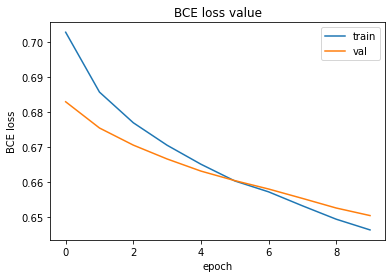

In [124]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

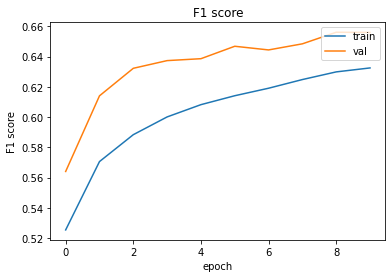

In [125]:
plt.plot(train_f1)
plt.plot(val_f1)
plt.title('F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

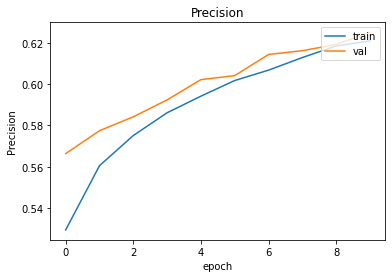

In [126]:
plt.plot(precs)
plt.plot(val_precs)
plt.title('Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

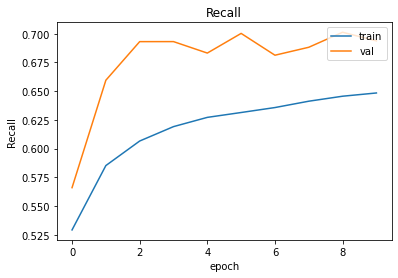

In [127]:
plt.plot(recs)
plt.plot(val_recs)
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Нет, лучше не стало, ну ничего :) Я, честно говоря, удивилена, но на это и гиперпараметры, чтобы их подбирать :)

Попробуем бахнуть ебмеддинги, которые мы получили, обучив FastText модельку на нашем датасете, думаю, тут точно должно улучшиться качество модели.


## Model 1 + FastText

In [139]:
model = CNN(len(word2id), 100, 1, pretrained_weights=ft_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

In [140]:
train_loss, val_loss, train_f1, val_f1, precs, val_precs, recs, val_recs = train(train_dataloader=train_dataloader,
                                               val_dataloader=val_dataloader,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=10,
                                               metric=f1)

 10%|█         | 1/10 [00:21<03:13, 21.45s/it]

Val loss: 0.6213200662855629, Val metric: 0.6631161570549011
----------
Epoch 1:
Train loss: 0.6396130939623467, Train metric: 0.6449798345565796


 20%|██        | 2/10 [00:42<02:51, 21.40s/it]

Val loss: 0.6104800644087361, Val metric: 0.6361954212188721
----------
Epoch 2:
Train loss: 0.6096295188692279, Train metric: 0.6756892204284668


 30%|███       | 3/10 [01:04<02:29, 21.34s/it]

Val loss: 0.5997631767311612, Val metric: 0.6603642106056213
----------
Epoch 3:
Train loss: 0.5982835314775768, Train metric: 0.6848755478858948


 40%|████      | 4/10 [01:25<02:07, 21.22s/it]

Val loss: 0.598058659348402, Val metric: 0.6400434970855713
----------
Epoch 4:
Train loss: 0.5895090215412297, Train metric: 0.6926665902137756


 50%|█████     | 5/10 [01:46<01:45, 21.19s/it]

Val loss: 0.5854043277937013, Val metric: 0.7062087059020996
----------
Epoch 5:
Train loss: 0.5831339357266748, Train metric: 0.6975019574165344


 60%|██████    | 6/10 [02:07<01:24, 21.22s/it]

Val loss: 0.5807184960928049, Val metric: 0.7016022801399231
----------
Epoch 6:
Train loss: 0.5788609355015862, Train metric: 0.7019743919372559


 70%|███████   | 7/10 [02:28<01:03, 21.28s/it]

Val loss: 0.5855445128840369, Val metric: 0.7309555411338806
----------
Epoch 7:
Train loss: 0.5748842898392139, Train metric: 0.7045432329177856


 80%|████████  | 8/10 [02:50<00:42, 21.31s/it]

Val loss: 0.5757030092918121, Val metric: 0.6961662769317627
----------
Epoch 8:
Train loss: 0.5716715093618049, Train metric: 0.7083660364151001


 90%|█████████ | 9/10 [03:11<00:21, 21.30s/it]

Val loss: 0.5787635535538733, Val metric: 0.6799172163009644
----------
Epoch 9:
Train loss: 0.5678395975801281, Train metric: 0.711850106716156


100%|██████████| 10/10 [03:32<00:00, 21.28s/it]

Val loss: 0.5721127232452771, Val metric: 0.7033324837684631
----------
Epoch 10:
Train loss: 0.5661381069654808, Train metric: 0.7119336724281311


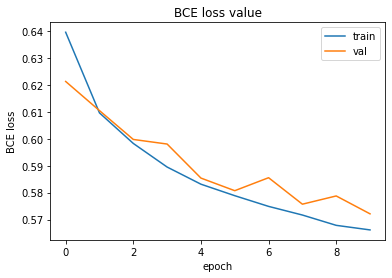

In [141]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

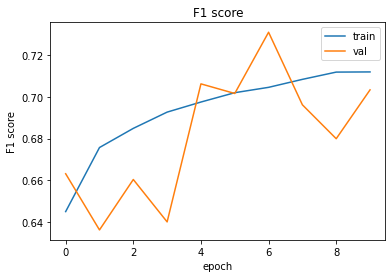

In [142]:
plt.plot(train_f1)
plt.plot(val_f1)
plt.title('F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

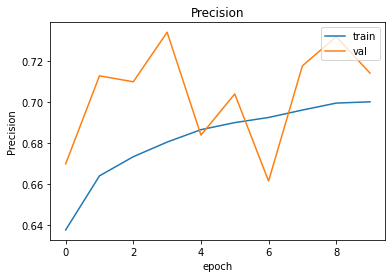

In [143]:
plt.plot(precs)
plt.plot(val_precs)
plt.title('Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

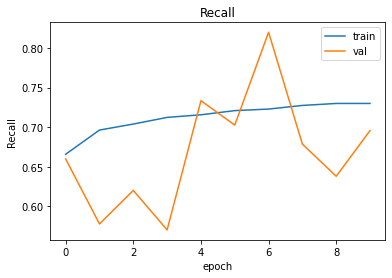

In [144]:
plt.plot(recs)
plt.plot(val_recs)
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Не улучшил фасттекст особо качество модели, но ничего страшного, опять же, при чуть другой архитектуре/при чуть других параметрах, может быть, все было бы и лучше)

В любом случае, совершенству нет предела, и можно и число эпох увеличивать, и какие-нибудь слои присобачивать еще (может, подумать что-то про аттеншн, почему нет, можно поприкручивать scheduler - я его указывала в аргументах, но для работы с моделью ниже, и с learning rate что-то думать, и с размерами эмбеддингов, и с размерами кернелов в пулинге и вообще свертках, в общем, простор для экспериментов огромный )

# WordSymDataset

посчитаем символы и отфильтруем по частоте встрпечаемости: порог 1.

In [153]:
syms = Counter()
for text in df['tokens2']:
    syms.update(list(text))
print(len(syms))

filtered_syms = set()
for s in syms.keys():
    if syms[s] > 1:
        filtered_syms.add(s)
print(len(filtered_syms))

171902
74082


Делаем словарики для маппинга символов в модельке, тут добавлен помимо 'PAD' еще и 'UNK' - чтобы при встрече "незнакомого" (того, который мы убрали после фильтрации) символа, ничего не поломалось

In [154]:
symbol2id = {'PAD':0, 'UNK': 1} 

for s in filtered_syms:
    symbol2id[s] = len(symbol2id)

id2symbol = {i:sorted for s, i in symbol2id.items()}

In [156]:
class WordSymbDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, device):
        self.dataset = dataset['tokens2'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = device

    def __len__(self):
        return self.length

    def __getitem__(self, idx): 
        tokens = self.dataset[idx]
        ids = torch.LongTensor([self.word2id[tok] for tok in tokens if tok in self.word2id])
        symbols = list(self.dataset[idx])
        s_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        y = [self.target[idx]]
        return ids, s_ids,  y


    def collate_fn(self, batch):
      ids, s_ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      padded_s = pad_sequence(s_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, padded_s, y


In [158]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 128

train_dataset = WordSymbDataset(train_df, word2id, symbol2id, device)
val_dataset = WordSymbDataset(val_df, word2id, symbol2id, device)

train_sampler = RandomSampler(train_dataset)
val_sampler = RandomSampler(val_dataset)

train_dataloader = DataLoader(train_dataset,
                              collate_fn = train_dataset.collate_fn,
                              sampler=train_sampler,
                              batch_size=batch_size)
val_dataloader = DataLoader(val_dataset,
                            collate_fn = val_dataset.collate_fn,
                            sampler=val_sampler,
                            batch_size=batch_size)

# Model 2 - комбинация эмбеддингов и символьных признаков

In [159]:
class WordSymbCNN(nn.Module):
  #надо было отнаследоваться по-нормальному от предыдущей модели, но мне стало проще скопировать часть кода - мб так проще чиатть код
    def __init__(self, word_vocab_size, symb_vocab_size,
                 word_embedding_dim, symb_embedding_dim,
                 pretrained_weights=None):
        super().__init__()
        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
        if pretrained_weights is not None:
            self.word_embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
            self.word_embedding.weight.requires_grad = False
        self.f1 = nn.Linear(in_features=word_embedding_dim, out_features=180)
        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=360, out_features=1)
        self.out = nn.Sigmoid()
    
    def forward(self, sentence, symbols):
        embedded_sent = self.word_embedding(sentence).mean(axis=1)
        embedded_sent = self.f1(embedded_sent)
        embedded_symb = self.symb_embedding(symbols)
        embedded_symb = embedded_symb..permute(0,2,1)
        feature_map_bigrams = self.pooling(self.relu(self.bigrams(embedded_symb)))
        feature_map_trigrams = self.pooling(self.relu(self.trigrams(embedded_symb)))
        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]

        concat = torch.cat((pooling1, pooling2, embedded_sent), 1)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [161]:
model = WordSymbCNN(len(word2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()


train_loss, val_loss, train_f1, val_f1, precs, val_precs, recs, val_recs  = train(train_dataloader=train_dataloader,
                                               val_dataloader=val_dataloader,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=10,
                                               metric=f1)

 10%|█         | 1/10 [00:40<06:06, 40.71s/it]

Val loss: 0.5608671613306075, Val metric: 0.7134450078010559
----------
Epoch 1:
Train loss: 0.6125612596147939, Train metric: 0.6537016034126282


 20%|██        | 2/10 [01:21<05:24, 40.54s/it]

Val loss: 0.5396865134437879, Val metric: 0.7312281131744385
----------
Epoch 2:
Train loss: 0.5083854094707876, Train metric: 0.7543188333511353


 30%|███       | 3/10 [02:01<04:43, 40.48s/it]

Val loss: 0.5521815038277759, Val metric: 0.7158852815628052
----------
Epoch 3:
Train loss: 0.4394436514467225, Train metric: 0.7990909814834595


 40%|████      | 4/10 [02:41<04:02, 40.42s/it]

Val loss: 0.5671658534388822, Val metric: 0.7418423891067505
----------
Epoch 4:
Train loss: 0.38300012138329054, Train metric: 0.8303481340408325


 50%|█████     | 5/10 [03:21<03:21, 40.28s/it]

Val loss: 0.636437973326391, Val metric: 0.692658543586731
----------
Epoch 5:
Train loss: 0.3301209643595201, Train metric: 0.8581399917602539


 60%|██████    | 6/10 [04:02<02:41, 40.29s/it]

Val loss: 0.7227145489808675, Val metric: 0.6699085831642151
----------
Epoch 6:
Train loss: 0.28770689825366313, Train metric: 0.878576397895813


 70%|███████   | 7/10 [04:42<02:00, 40.22s/it]

Val loss: 0.7259820611761497, Val metric: 0.7194823622703552
----------
Epoch 7:
Train loss: 0.25056919921609694, Train metric: 0.8962203860282898


 80%|████████  | 8/10 [05:22<01:20, 40.35s/it]

Val loss: 0.7866294587383399, Val metric: 0.7222548723220825
----------
Epoch 8:
Train loss: 0.22127190395853574, Train metric: 0.9090368747711182


 90%|█████████ | 9/10 [06:02<00:40, 40.14s/it]

Val loss: 0.8751041216121332, Val metric: 0.6795601844787598
----------
Epoch 9:
Train loss: 0.19675632570134965, Train metric: 0.9200968146324158


100%|██████████| 10/10 [06:42<00:00, 40.24s/it]

Val loss: 0.9089444605549714, Val metric: 0.685820460319519
----------
Epoch 10:
Train loss: 0.17496563086104125, Train metric: 0.9297754168510437


In [162]:
print(train_loss[-1], train_f1[-1], precs[-1], recs[-1])
print(val_loss[-1], val_f1[-1], val_precs[-1], val_recs[-1])

0.17496563086104125 0.9297754 0.9337303 0.9278944
0.9089444605549714 0.68582046 0.7381414 0.6434901


In [169]:
loss_ans = []
f1_ans = []
precision_ans = []
recall_ans = []
model_type = []
loss_ans.append(val_loss[-1])
f1_ans.append(val_f1[-1])
precision_ans.append(val_precs[-1])
recall_ans.append(val_recs[-1])
model_type.append('WordSymbCNN-1')
df_ans = pd.DataFrame({'Model type': model_type,
                       'Precision': precision_ans,
                       'Recall': recall_ans,
                       'F1': f1_ans,
                       'Loss': loss_ans})
df_ans

,Model type,Precision,Recall,F1,Loss
0,WordSymbCNN-1,0.738141,0.64349,0.68582,0.908944


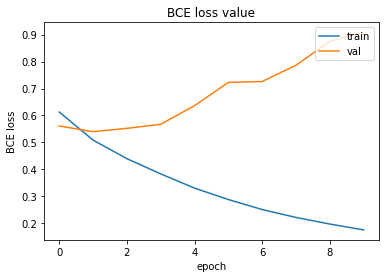

In [164]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Явно переобучается моделька, ничего, добавим опять дропауты, поправим (еще посмотрим на эмбеддингах, как дела)

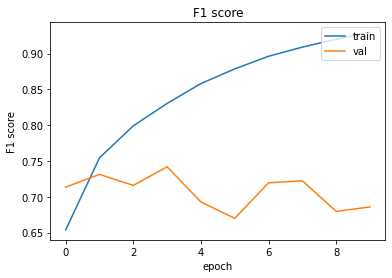

In [165]:
plt.plot(train_f1)
plt.plot(val_f1)
plt.title('F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [170]:
model = WordSymbCNN(len(word2id), len(symbol2id), 100, 10, ft_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()


train_loss, val_loss, train_f1, val_f1, precs, val_precs, recs, val_recs = train(train_dataloader=train_dataloader,
                                               val_dataloader=val_dataloader,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               epochs=10,
                                               metric=f1)

 10%|█         | 1/10 [00:26<03:58, 26.55s/it]

Val loss: 0.6201077411706383, Val metric: 0.6880373358726501
----------
Epoch 1:
Train loss: 0.6398305908629769, Train metric: 0.6418803334236145


 20%|██        | 2/10 [00:53<03:36, 27.04s/it]

Val loss: 0.5813600383363329, Val metric: 0.7070981860160828
----------
Epoch 2:
Train loss: 0.5862764103296108, Train metric: 0.6904535293579102


 30%|███       | 3/10 [01:20<03:08, 26.96s/it]

Val loss: 0.5639775492049552, Val metric: 0.7194370627403259
----------
Epoch 3:
Train loss: 0.5403225050832993, Train metric: 0.728084146976471


 40%|████      | 4/10 [01:47<02:41, 26.84s/it]

Val loss: 0.5557218187631251, Val metric: 0.7228227257728577
----------
Epoch 4:
Train loss: 0.505250076803946, Train metric: 0.7545382380485535


 50%|█████     | 5/10 [02:14<02:13, 26.78s/it]

Val loss: 0.5556117067331666, Val metric: 0.7292435169219971
----------
Epoch 5:
Train loss: 0.4746407424820993, Train metric: 0.7748889327049255


 60%|██████    | 6/10 [02:40<01:47, 26.75s/it]

Val loss: 0.5583759303297009, Val metric: 0.7233894467353821
----------
Epoch 6:
Train loss: 0.4462967282623277, Train metric: 0.7931115627288818


 70%|███████   | 7/10 [03:07<01:20, 26.72s/it]

Val loss: 0.5714888545843932, Val metric: 0.7052024006843567
----------
Epoch 7:
Train loss: 0.41966481836218583, Train metric: 0.8085206747055054


 80%|████████  | 8/10 [03:34<00:53, 26.66s/it]

Val loss: 0.5765783257849582, Val metric: 0.7381089925765991
----------
Epoch 8:
Train loss: 0.39487632271042444, Train metric: 0.8240994215011597


 90%|█████████ | 9/10 [04:00<00:26, 26.62s/it]

Val loss: 0.5863878572577829, Val metric: 0.7298073768615723
----------
Epoch 9:
Train loss: 0.3701058869299136, Train metric: 0.8379091620445251


100%|██████████| 10/10 [04:27<00:00, 26.73s/it]

Val loss: 0.6085547840742914, Val metric: 0.7074964642524719
----------
Epoch 10:
Train loss: 0.3477216012943956, Train metric: 0.8499179482460022


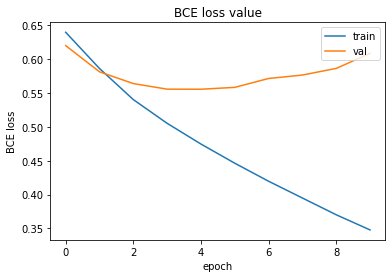

In [171]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

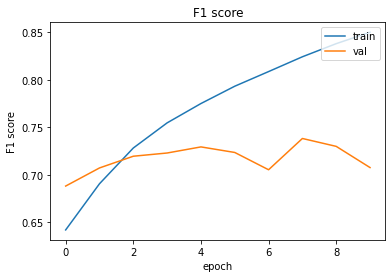

In [172]:
plt.plot(train_f1)
plt.plot(val_f1)
plt.title('F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [173]:
loss_ans.append(val_loss[-1])
f1_ans.append(val_f1[-1])
precision_ans.append(val_precs[-1])
recall_ans.append(val_recs[-1])
model_type.append('WordSymbCNN-1+FastText')
df_ans = pd.DataFrame({'Model type': model_type,
                       'Precision': precision_ans,
                       'Recall': recall_ans,
                       'F1': f1_ans,
                       'Loss': loss_ans})
df_ans

,Model type,Precision,Recall,F1,Loss
0,WordSymbCNN-1,0.738141,0.643490,0.685820,0.908944
1,WordSymbCNN-1+FastText,0.748705,0.674129,0.707496,0.608555


Класс, стало лучше!!! Сейчас шедулер еще поставим, вдруг что там

In [180]:
model = WordSymbCNN(len(word2id), len(symbol2id), 100, 10, ft_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-1)
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

train_loss, val_loss, train_f1, val_f1, precs, val_precs, recs, val_recs = train(train_dataloader=train_dataloader,
                                               val_dataloader=val_dataloader,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               scheduler=scheduler,
                                               epochs=10,
                                               metric=f1)

 10%|█         | 1/10 [00:26<04:00, 26.68s/it]

Val loss: 3.025414787031509, Val metric: 0.6709065437316895
----------
Epoch 1:
Train loss: 2.8420552439707563, Train metric: 0.6127773523330688


 20%|██        | 2/10 [00:53<03:33, 26.73s/it]

Val loss: 4.048208456318657, Val metric: 0.5273041725158691
----------
Epoch 2:
Train loss: 3.412333843448108, Train metric: 0.6670392751693726


 30%|███       | 3/10 [01:20<03:07, 26.80s/it]

Val loss: 4.669807311751552, Val metric: 0.6462788581848145
----------
Epoch 3:
Train loss: 3.85491786451268, Train metric: 0.693120539188385


 40%|████      | 4/10 [01:47<02:41, 26.89s/it]

Val loss: 6.726573196315282, Val metric: 0.5998062491416931
----------
Epoch 4:
Train loss: 5.2939891073936804, Train metric: 0.7031210660934448


 50%|█████     | 5/10 [02:14<02:14, 26.99s/it]

Val loss: 9.023942545593322, Val metric: 0.7204782366752625
----------
Epoch 5:
Train loss: 5.407264187506267, Train metric: 0.7179933190345764


 60%|██████    | 6/10 [02:41<01:47, 26.97s/it]

Val loss: 32.19323608467171, Val metric: 0.6971456408500671
----------
Epoch 6:
Train loss: 9.029502030960598, Train metric: 0.7303672432899475


 70%|███████   | 7/10 [03:08<01:20, 26.89s/it]

Val loss: 34.651826940141284, Val metric: 0.6570864915847778
----------
Epoch 7:
Train loss: 30.997877295931477, Train metric: 0.7389075756072998


 80%|████████  | 8/10 [03:35<00:53, 26.89s/it]

Val loss: 33.40049324379311, Val metric: 0.6816728711128235
----------
Epoch 8:
Train loss: 29.811479612938445, Train metric: 0.7288697957992554


 90%|█████████ | 9/10 [04:01<00:26, 26.89s/it]

Val loss: 36.211029551050686, Val metric: 0.6881373524665833
----------
Epoch 9:
Train loss: 29.90628501347133, Train metric: 0.7234714031219482


100%|██████████| 10/10 [04:28<00:00, 26.86s/it]

Val loss: 34.934856255849205, Val metric: 0.6714352369308472
----------
Epoch 10:
Train loss: 31.861353581650814, Train metric: 0.7148261666297913


In [181]:
loss_ans.append(val_loss[-1])
f1_ans.append(val_f1[-1])
precision_ans.append(val_precs[-1])
recall_ans.append(val_recs[-1])
model_type.append('WordSymbCNN-1+FastText')
df_ans = pd.DataFrame({'Model type': model_type,
                       'Precision': precision_ans,
                       'Recall': recall_ans,
                       'F1': f1_ans,
                       'Loss': loss_ans})
df_ans

,Model type,Precision,Recall,F1,Loss
0,WordSymbCNN-1,0.738141,0.643490,0.685820,0.908944
1,WordSymbCNN-1+FastText,0.748705,0.674129,0.707496,0.608555
2,WordSymbCNN-1+FastText,0.505923,1.000000,0.670618,49.407728
3,WordSymbCNN-1+FastText,0.639466,0.711202,0.671435,34.934856


тут у меня не надо обращать на строчку 2 - это САМЫЙ НЕУДАЧНЫЙ ЭКСПЕРИМЕНТ И я на горестях убрала кодовые ячейки - это очень смешно (просто гавесила дропаут " не туда" и все попротилось)))

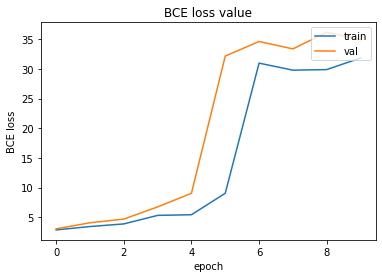

In [182]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

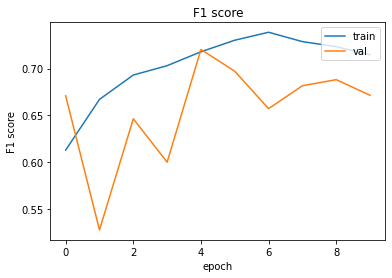

In [183]:
plt.plot(train_f1)
plt.plot(val_f1)
plt.title('F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Итог работы этой модели: конечно, случился очень сильный буст, это здорово,  так как символьная информация тоже повышает обобщающую способность модели

Дропаут замечательно решал проблему перееобучения

Дополнительная информация с эмбеддингов также помогла повысить performance  модели

Я провела много экспериментов, комментировала их, визуализировала процесс обучения, смотрела много глзками на качество модели. Такой подробный анализ также помог найти лучший подход.

# Анализ ошибок

Прросто выведем предложения и посмотрим на них.

В реальной жизни (по крайней мере, в моей) проходит несколько итерация разметок, так как человеческий фактор в разметке присутсвтует всегда, а еще иногда в целом есть "шумные"/"мусорные" примеры, которые стоит учитывать, а иногда надо чуть поменять разметку, поэтому попробую сама проинтерпретировать результаты)

эх моя свадьба не скоро будет -  возможно, слово "свадьба", которое очень часто встречается именно в позитивном контексте, имело существенный вес при определении класса


завтра будет целый день переживаний за тебя как ты там - для меня это максимально "нейтральный контекст", как и большиснтво предложений ниже

а тут, когда сам человек не знает, к какому классу отнести предложение, то модели уж тем более сложно

вывод такой: всегда хороша переразметка "трудных" случаев и дальшая новая работа с моделями

In [185]:
for (*x, y) in val_dataloader:
    break

y = y.long().detach().cpu().numpy().T[0] 
with torch.no_grad():
    preds = model(*x).round().long().detach().cpu().numpy().T[0]
words = x[0].detach().cpu().numpy()
sents = []
for sent in words:
    sents.append(' '.join([id2word[i] for i in sent if i!=0]))
sents = np.array(sents)
ids = np.where(preds != y)[0]
for id in ids[:20]:
    print('label:', y[id])
    print('pred:', preds[id])
    print(sents[id])
    print()

label: 1
pred: 0
соня даже не понимаю чему ты это

label: 1
pred: 0
вот так надо худеть

label: 0
pred: 1
верните меня прошлое там было такое прекрасное будущее

label: 0
pred: 1
_ __ ох котя

label: 0
pred: 1
заяш коза разбудила блять ну зачем ты так делаешь

label: 0
pred: 1
мы мы потом она

label: 0
pred: 1
божественный мужчина предложить поотбивать ним ноги субботу это так романтично ахаха блин ну жена

label: 0
pred: 1
так приятно когда идёшь по улице тебе вслед смотрят парни ты улыбаешься зная том что принадлежишь только одному

label: 0
pred: 1
какая ты красивая сегодня влюбилась ты что поправилась на кг меня круги под глазами так это ты влюбилась

label: 0
pred: 1
сам себя уничиожил настроение на ноле

label: 0
pred: 1
тебе згадував недавно ахуєть тебе кожен день згадую

label: 0
pred: 1
уже

label: 0
pred: 1
эти слова краеугольным камнем лежат меня на сердце

label: 0
pred: 1
через несколько часов мы окажемся дома

label: 0
pred: 1
надеюсь что этот год будет лучше чем уходящий